# 05 Analysis of single cell dataset

- Åsa Björklund
- Paulo Czarnewski

- Spatial Omics Data Analysis 2022

In this tutorial, we will perform analysis of the single cell data, which will be used in combination with the Spatial transcripomics and the _in situ_ sequencing data to produce even more refined results. Please note that this tutorial is a brief overview of the methods and functions commonly used in single cell. If you are unfaminiar with such analysis, we recomend you to follow first the Single Cell Data Analysis course: https://nbisweden.github.io/workshop-scRNAseq/exercises

***

## Loading libraries

In [11]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import scanorama
import os

sc.settings.set_figure_params(dpi=80)
# sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

***

## Loading the dataset

In this tutorial, we will perform analysis of the single cell data, which will be used in combination with the Spatial transcripomics and the _in situ_ sequencing data to produce even more refined results. Please note that this tutorial is a brief overview of the methods and functions commonly used in single cell. If you are unfaminiar with such analysis, we recomend you to follow first the Single Cell Data Analysis course: https://nbisweden.github.io/workshop-scRNAseq/exercises

In [12]:
adata = sc.read_h5ad('../results/single_cell/scRNAseq.h5ad')
adata

AnnData object with n_obs × n_vars = 25601 × 33538
    obs: 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'

***

##  Calculate QC

Having the data in a suitable format, we can start calculating some quality metrics. We can for example calculate the percentage of mitocondrial and ribosomal genes per cell and add to the metadata. This will be helpfull to visualize them across different metadata parameteres (i.e. datasetID and chemistry version). There are several ways of doing this, and here manually calculate the proportion of mitochondrial reads and add to the metadata table.

Citing from "Simple Single Cell" workflows (Lun, McCarthy & Marioni, 2017): 
_"High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane."_

First, let Scanpy calculate some general qc-stats for genes and cells with the function `sc.pp.calculate_qc_metrics`, similar to `calculateQCmetrics` in Scater. It can also calculate proportion of counts for specific gene populations, so first we need to define which genes are mitochondrial, ribosomal and hemoglogin.

In [13]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

,gene_ids,feature_types,genome,mt,ribo,hb
FAM138A,FAM138A,Gene Expression,undefined,False,False,False
AL627309.1,AL627309.1,Gene Expression,undefined,False,False,False
AL627309.3,AL627309.3,Gene Expression,undefined,False,False,False
AL627309.2,AL627309.2,Gene Expression,undefined,False,False,False
OR4F29,OR4F29,Gene Expression,undefined,False,False,False
...,...,...,...,...,...,...
TTTY4B,TTTY4B,Gene Expression,undefined,False,False,False
BPY2B,BPY2B,Gene Expression,undefined,False,False,False
DAZ4,DAZ4,Gene Expression,undefined,False,False,False
CDY1,CDY1,Gene Expression,undefined,False,False,False


In [14]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

Now you can see that we have additional data in the scanpy `obs` slot.

In [15]:
mito_genes = adata.var_names.str.startswith('MT-')

# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata

AnnData object with n_obs × n_vars = 25601 × 33538
    obs: 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Now we can plot some of the QC-features as violin plots.

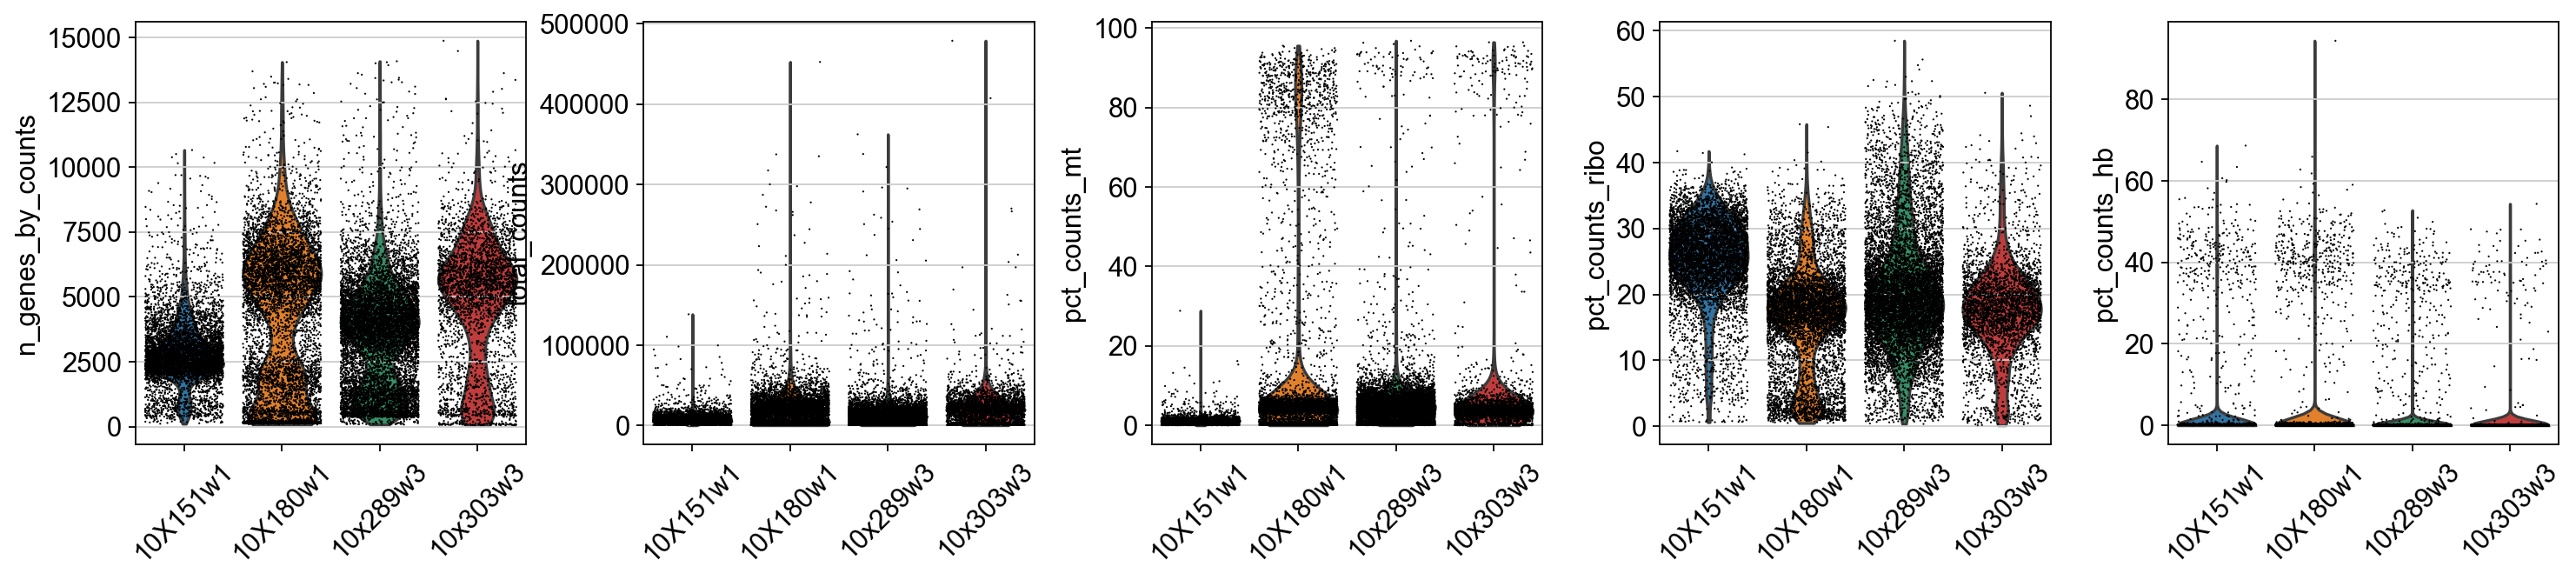

In [16]:
variables = ['n_genes_by_counts', 'total_counts', 
        'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb']
sc.pl.violin(adata, variables, jitter=0.4, groupby = 'sample_id', rotation= 45)

As you can see, there is quite some difference in quality between the datasets. As the ribosomal proteins are highly expressed they will make up a larger proportion of the transcriptional landscape when fewer of the lowly expressed genes are detected. We can plot the different QC-measures as scatter plots.

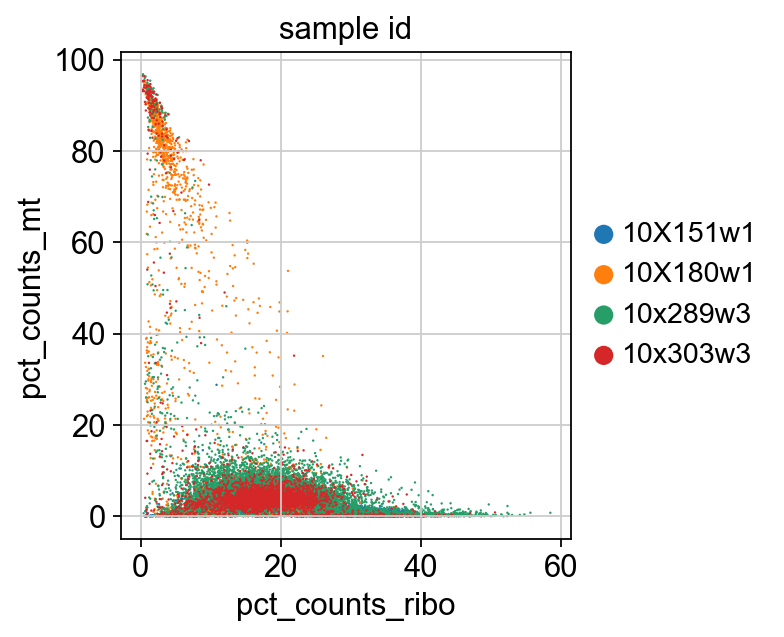

In [17]:
sc.pl.scatter(adata, x='pct_counts_ribo', y='pct_counts_mt', color="sample_id")

***

## Cell and gene Filtering

A standard approach is to filter cells with low amount of reads as well as genes that are present in at least a certain amount of cells. Here we will only consider cells with at least 200 detected genes and genes need to be expressed in at least 3 cells. Please note that those values are highly dependent on the library preparation method used.

In [18]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 726 cells that have less than 200 genes expressed
filtered out 5460 genes that are detected in less than 3 cells
24875 28078


Extremely high number of detected genes could indicate doublets. However, depending on the cell type composition in your sample, you may have cells with higher number of genes (and also higher counts) from one cell type.

***

## Normalization

Before cell cycle and variable gene selection we have to normalize the data. In the scanpy object, the data slot will be overwritten with the normalized data. So first, save the raw data into the slot raw. Here, we perform the `log(CP10K)` normalization.

In [19]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10000 UMIs per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


***

## Calculate cell-cycle scores

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at [RegevLab Github repo](https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt).

In [24]:
# Create folder
os.makedirs('../results/supplementary_files', exist_ok=True)

request.urlretrieve(
    url      = 'https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt',
    filename = '../results/supplementary_files/regev_lab_cell_cycle_genes.txt' )

('../results/supplementary_files/regev_lab_cell_cycle_genes.txt',
 <http.client.HTTPMessage at 0x168773100>)

In [ ]:
# Load gene list from file
cell_cycle_genes = [x.strip() for x in open('../results/regev_lab_cell_cycle_genes.txt')]

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# Filter out genes not detectd in our dataset 
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

We here perform cell cycle scoring. The function is actually a wrapper to sc.tl.score_gene_list, which is launched twice, to score separately S and G2M phases. Both sc.tl.score_gene_list and sc.tl.score_cell_cycle_genes are a port from Seurat and are supposed to work in a very similar way. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

In [ ]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

We can now plot a violin plot for the cell cycle scores as well.

In [ ]:
sc.pl.violin(adata, ['S_score', 'G2M_score'], jitter=0.4, groupby = 'sample_id', rotation=45)

In this case it looks like we only have a few cycling cells in the datasets.

## Variable feature selection

Next, we first need to define which features/genes are important in our dataset to distinguish cell types. For this purpose, we need to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.

In [ ]:
# compute variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))

In [ ]:
#plot variable genes
sc.pl.highly_variable_genes(adata)

# subset for variable genes in the dataset
adata = adata[:, adata.var['highly_variable']]

Now that the data is prepared, we now proceed with PCA. Since each gene has a different expression level, it means that genes with higher expression values will naturally have higher variation that will be captured by PCA. This means that we need to somehow give each gene a similar weight when performing PCA (see below). The common practice is to center and scale each gene before performing PCA. This exact scaling is called Z-score normalization it is very useful for PCA, clustering and plotting heatmaps.

Additionally, we can use regression to remove any unwanted sources of variation from the dataset, such as cell cycle, sequencing depth, percent mitocondria. This is achieved by doing a generalized linear regression using these parameters as covariates in the model. Then the residuals of the model are taken as the "regressed data". Although perhaps not in the best way, batch effect regression can also be done here.

In [ ]:
# adata = adata.copy()     #run this line if you get the "AttributeError: swapaxes not found" 

# regress out unwanted variables
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale data, clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

You can explore the list of highly variable genes with this command:

In [ ]:
adata.var.highly_variable

***

## Dimensionality reduction with `PCA`

Performing PCA has many useful applications and interpretations, which much depends on the data used. In the case of life sciences, we want to segregate samples based on gene expression patterns in the data.

In [ ]:
sc.tl.pca(
    data = adata, 
    svd_solver = 'arpack',
    n_comps = 50,
    use_highly_variable = True)

We then plot the first principal components.

In [ ]:
sc.pl.pca(adata, color='sample_id', components = ['1,2','3,4','5,6','7,8'], ncols=2)

Lets save the QC-filtered data for further analysis. Create output directory results and save data to that folder.

In [ ]:
os.makedirs('../results/single_cell', exist_ok=True)
adata.write_h5ad('../results/single_cell/single_cell_qc.h5ad')

***

## Data integration with `Scanorama`

First we need to create individual AnnData objects from each of the datasets. Variable genes can be detected across the full dataset, but then we run the risk of getting many batch-specific genes that will drive a lot of the variation. Or we can select variable genes from each batch separately to get only celltype variation. In the dimensionality reduction exercise, we already selected variable genes, so they are already stored in `adata.var.highly_variable`.

In [ ]:
adata = sc.read_h5ad('../results/single_cell/single_cell_qc.h5ad')
adata

In [ ]:
# split per batch into new objects.
batches = adata.obs['sample_id'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['sample_id'] == batch,]

To run Scanorama, you need to install python-annoy (already included in conda environment) and scanorama with pip. We can run scanorama to get a corrected matrix with the correct function, or to just get the data projected onto a new common dimension with the function integrate. Or both with the correct_scanpy and setting `return_dimred=True`. For now, run with just integration.

In [ ]:
#convert to list of AnnData objects
adatas = list(alldata.values())

In [ ]:
#Check scanorama.integrate() for documentation of parameters
scanorama.integrate_scanpy(
    adatas        = adatas,
    dimred        = 50)

Scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.

In [ ]:
adatas[0].obsm['X_scanorama'].shape

We can get all those matrices back to the original dataset. like so:

In [ ]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object
adata.obsm["scanorama"] = all_s

In [ ]:
# Remove other objects from memory
del(all_s,scanorama_int,adatas)

In [ ]:
sc.pl.embedding(
    basis='scanorama',
    adata = adata,
    color='sample_id', 
    components = ['1,2','3,4','5,6','7,8'], 
    ncols=2)

***

## Data visualization with `UMAP`

We can now run UMAP for cell embeddings. The UMAP implementation in SCANPY uses a neighborhood graph as the distance matrix, so we need to first calculate the graph.

In [ ]:
sc.pp.neighbors(adata, n_pcs = 50, n_neighbors = 20, use_rep='scanorama')

Now we can run UMAP.

In [ ]:
sc.tl.umap(adata,min_dist=0.3,spread=0.5,maxiter=150)

In [ ]:
sc.pl.umap(adata, color='sample_id')

Lets save the work from these steps:

In [ ]:
os.makedirs('../results/single_cell', exist_ok=True)
adata.write_h5ad('../results/single_cell/single_cell_qc_int_dr.h5ad')

## Graph clustering

The procedure of clustering on a Graph can be generalized as 3 main steps:

1) Build a kNN graph from the data
2) Prune spurious connections from kNN graph (optional step). This is a SNN graph.
3) Find groups of cells that maximizes the connections within the group compared other groups.

If you recall from the integration, we already constructed a knn graph before running UMAP. Hence we do not need to do it again, and can run the community detection right away.

The modularity optimization algoritm in Scanpy are Leiden and Louvain. Lets test both and see how they compare.

In [ ]:
resolutions = [0.4,0.6,0.8,0.9,1.0,1.1,1.2,1.4,1.6]

In [ ]:
for i in resolutions:
    sc.tl.louvain( adata, resolution = i, key_added = "louvain_"+str(i) )
    sc.tl.leiden(  adata, resolution = i, key_added = "leiden_"+str(i) )

We can visualize the clusters obtained:

In [ ]:
all_clusterings = [ ('louvain_'+str(i)) for i in resolutions] + [ ('leiden_'+str(i)) for i in resolutions ]

In [ ]:
sc.pl.umap(adata = adata, color=all_clusterings , ncols=3 )

As you can see, with increased resolution, we get higher granularity in the clustering.

Lets save the integrated data for further analysis.

In [ ]:
os.makedirs('../results/single_cell', exist_ok=True)
adata.write_h5ad('../results/single_cell/single_cell_qc_int_dr_cl.h5ad')

***

## Differential gene expression

Once we have done clustering, let's compute a ranking for the highly differential genes in each cluster.
Differential expression is performed with the function rank_genes_group. The default method to compute differential expression is the t-test_overestim_var. Other implemented methods are: logreg, t-test and wilcoxon.

By default, the `.raw` attribute of AnnData is used in case it has been initialized, it can be changed by setting `use_raw=False`. The `leiden_0.6` clustering resolution seems to give a reasonable number of clusters, so we will use that clustering for all DE tests.

In [ ]:
adata = sc.read_h5ad('../results/single_cell/single_cell_qc_int_dr_cl.h5ad')
adata

In [ ]:
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:15])

As you can see, the X matrix only contains the variable genes, while the raw matrix contains all genes.
Printing a few of the values in adata.raw.X shows that the raw matrix is not normalized.
For DGE analysis we would like to run with all genes, but on normalized values, so we will have to revert back to the raw matrix and renormalize.

In [ ]:
adata = adata.raw.to_adata()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Soneson & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

In [ ]:
# Computing differential gene wilcoxon tests (one-vs-rest)
sc.tl.rank_genes_groups(adata, groupby = 'leiden_0.6', method='wilcoxon', key_added = "wilcoxon")

In [ ]:
# Computing differential gene t-tests (one-vs-rest)
sc.tl.rank_genes_groups(adata, groupby = 'leiden_0.6', method='t-test', key_added = "t-test")

In [ ]:
# Plotting top markers per cluster
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key="t-test")

In [ ]:
# Dotplot for the top 5 marker genes per cluster
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="t-test", groupby="leiden_0.6")